<h1>Where The Best Place to live in Bangkok, Thailand(with Foursquare API)<h1>

<p>Woraphun A., May 2020<p>

<img src="image/building-4108931_1280.JPG" width="85%" />

<h3>Introduction<h3>

<p>Bangkok is an exciting and vibrant city of over 12 million people. The greater metropolitan area of Bangkok extends for more than 32 kilometres (20 miles) in all directions. Situated in the central plains of Thailand, on the Chao Phraya River near the Gulf of Thailand, Bangkok is Thailand's administrative, economic, and cultural centre, as well as a major commercial and transportation hub for South-east Asia<p>

<p>The aim of this project is to classification the neighborhood in Bangkok by looking into their surrounding venues (using Foursquare API) and data analysis,K-means clustering, to figure out the main clusters.<\p>

<p>And hopefully, this analysis would be useful for someone who is planning to move to Bangkok and would like to find a place that fits their lifestyle and interests.<p>

<h3>Data section<h3>

<p>In this project I will mainly use data from Foursquare API and data about Bangkok's district from wikipedia  <p>

<p>Let's start with install all used packages<p>

In [1]:
pip  install geopy

     |████████████████████████████████| 122kB 24.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict

# map rendering library
!pip install folium
import folium

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
import xml.etree.ElementTree as et 

print("Done!")

     |████████████████████████████████| 122kB 24.6MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 14.3MB/s eta 0:00:01
Done!


<p>Retrive a list of the districts in Bangkok and their coordinates<p>

In [4]:
import pandas as pd

import requests

from bs4 import BeautifulSoup


req = requests.get("https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))

BKK_data =pd.DataFrame(df[0])

BKK_data.head(10)

,District(Khet),Postcode,Thai,Population,No. ofSubdistricts(Khwaeng),Latitude,Longitude
0,Bang Bon,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,10160,บางแค,191781,4,13.696111,100.409444
3,Bang Khen,10220,บางเขน,189539,2,13.873889,100.596389
4,Bang Kho Laem,10120,บางคอแหลม,94956,3,13.693333,100.502500
5,Bang Khun Thian,10150,บางขุนเทียน,165491,2,13.660833,100.435833
6,Bang Na,10260,บางนา,95912,2,13.680081,100.591800
7,Bang Phlat,10700,บางพลัด,99273,4,13.793889,100.505000
8,Bang Rak,10500,บางรัก,45875,5,13.730833,100.524167
9,Bang Sue,10800,บางซื่อ,132234,2,13.809722,100.537222


In [5]:
address = 'Bangkok'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok are 13.7542529, 100.493087.


<p>Visualize the District in Bangkok<p>

In [6]:
map_BKK = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(BKK_data['Latitude'], BKK_data['Longitude'], BKK_data['District(Khet)']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BKK)  
    
map_BKK

<p>Using Foursquare API to get venues data<p>

In [7]:
CLIENT_ID = 'GFWJDGGPY1Z3HK0LCHDTTM5CZO3SYOAU5VFT0IH0ZXRM4RCS'
CLIENT_SECRET = 'JWGXIALXWPRADXP1OTL2B0EPQVEWQBHGFWL5DGPDWOQXIWQB'
VERSION = '20190718'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GFWJDGGPY1Z3HK0LCHDTTM5CZO3SYOAU5VFT0IH0ZXRM4RCS
CLIENT_SECRET:JWGXIALXWPRADXP1OTL2B0EPQVEWQBHGFWL5DGPDWOQXIWQB


In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # radius around every metro station

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...,Buddhist Temple,13.751735,100.492651
1,Café VeloDome (คาเฟ่ เวโลโดม),Café,13.755783,100.491980
2,Prasat Phra Thep Bidon (ปราสาทพระเทพบิดร),Palace,13.751606,100.492720
3,Thokkathan-Mother Earth Squeezing Her Hair (พร...,Spiritual Center,13.756602,100.494767
4,The Grand Palace (พระบรมมหาราชวัง),Palace,13.751150,100.491615


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District(Khet)', 
                  'DistrictLatitude', 
                  'DistrictLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [11]:
BKK_venues = getNearbyVenues(names=BKK_data['District(Khet)'],
                                   latitudes=BKK_data['Latitude'],
                                   longitudes=BKK_data['Longitude']
                                  )

BKK_venues.head()

Bang Bon
Bang Kapi
Bang Khae
Bang Khen
Bang Kho Laem
Bang Khun Thian
Bang Na
Bang Phlat
Bang Rak
Bang Sue
Bangkok Noi
Bangkok Yai
Bueng Kum
Chatuchak
Chom Thong
Din Daeng
Don Mueang
Dusit
Huai Khwang
Khan Na Yao
Khlong Sam Wa
Khlong San
Khlong Toei
Lak Si
Lat Krabang
Lat Phrao
Min Buri
Nong Chok
Nong Khaem
Pathum Wan
Phasi Charoen
Phaya Thai
Phra Khanong
Phra Nakhon
Pom Prap Sattru Phai
Prawet
Rat Burana
Ratchathewi
Sai Mai
Samphanthawong
Saphan Sung
Sathon
Suan Luang
Taling Chan
Thawi Watthana
Thon Buri
Thung Khru
Wang Thonglang
Watthana
Yan Nawa


,District(Khet),DistrictLatitude,DistrictLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
2,Bang Bon,13.6592,100.3991,Lotus Express (โลตัส เอ็กซ์เพรส),13.657839,100.397243,Convenience Store
3,Bang Bon,13.6592,100.3991,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant
4,Bang Bon,13.6592,100.3991,ส.ทิพรส,13.659368,100.399382,Noodle House


In [12]:
cat_4sqr =pd.read_csv("4sqr_cat.txt",delimiter=":")
cat_4sqr.columns = ["VenueCategory", "MainCategory"]

In [13]:
CAT = pd.DataFrame(cat_4sqr)
CAT.head(10)

,VenueCategory,MainCategory
0,Multiplex,Movie Theater
1,Art Museum,Museum
2,Erotic Museum,Museum
3,History Museum,Museum
4,Planetarium,Museum
5,Science Museum,Museum
6,Jazz Club,Music Venue
7,Piano Bar,Music Venue
8,Rock Club,Music Venue
9,Dance Studio,Performing Arts Venue


In [14]:
BKK_main_categories=BKK_venues
BKK_main_cat=BKK_main_categories.merge(CAT, how='left', on='VenueCategory')
BKK_main_cat.head()

,District(Khet),DistrictLatitude,DistrictLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,MainCategory
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant,Asian Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant,Asian Restaurant
2,Bang Bon,13.6592,100.3991,Lotus Express (โลตัส เอ็กซ์เพรส),13.657839,100.397243,Convenience Store,Shop & Service
3,Bang Bon,13.6592,100.3991,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant,Food
4,Bang Bon,13.6592,100.3991,ส.ทิพรส,13.659368,100.399382,Noodle House,Asian Restaurant


In [15]:
BKK_venues1 = BKK_main_cat['MainCategory'].value_counts().sort_values(ascending=False).head()
BKK_venues1

Food                   433
Asian Restaurant       248
Shop & Service         165
Japanese Restaurant     27
Nightlife Spot          21
Name: MainCategory, dtype: int64

In [16]:
BKK_venue3 = BKK_main_cat.MainCategory.isna().sum()
BKK_venue3

101

<h3>Data Methodology<\h3>

In [17]:
cat_grouped=BKK_main_cat.groupby('MainCategory')['VenueCategory'].count().reset_index()
cat_grouped['Percent'] = cat_grouped['VenueCategory']/cat_grouped['VenueCategory'].sum()*100
cat_grouped=cat_grouped.sort_values('Percent', ascending=False)
cat_grouped.round({'Percent': 1})

,MainCategory,VenueCategory,Percent
8,Food,433,42.2
1,Asian Restaurant,248,24.1
24,Shop & Service,165,16.1
13,Japanese Restaurant,27,2.6
18,Nightlife Spot,21,2.0
9,Food & Drink Shop,20,1.9
0,Arts & Entertainment,19,1.9
3,Bar,17,1.7
12,Hotel,15,1.5
20,Outdoors & Recreation,13,1.3


In [18]:
cat_grouped_detail=BKK_main_cat.groupby('VenueCategory')['MainCategory'].count().reset_index()
cat_grouped_detail=cat_grouped_detail.sort_values('MainCategory', ascending=False)
cat_grouped_detail.head(10)

,VenueCategory,MainCategory
101,Noodle House,126
30,Coffee Shop,75
33,Convenience Store,70
143,Thai Restaurant,63
24,Café,57
2,Asian Restaurant,48
27,Chinese Restaurant,35
80,Japanese Restaurant,32
38,Dessert Shop,25
47,Fast Food Restaurant,21


<p>Calculate the number of venues per District and get descriptive statistics with a boxplot<\p>

In [19]:
venues_grouped = BKK_main_cat.groupby('District(Khet)')['Venue'].count().reset_index()
venues_grouped.head()

,District(Khet),Venue
0,Bang Bon,10
1,Bang Kapi,22
2,Bang Khae,10
3,Bang Khen,15
4,Bang Kho Laem,18


In [20]:
venues_grouped.describe()

,Venue
count,50.000000
mean,22.560000
std,17.656773
min,4.000000
25%,10.000000
50%,19.000000
75%,28.750000
max,89.000000


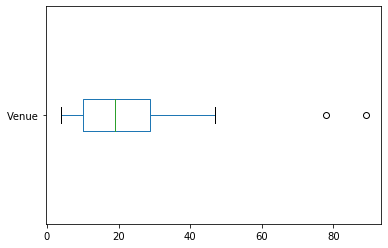

In [21]:
venues_grouped.plot.box(vert=False)

In [22]:
BKK_venues_2 = BKK_main_cat.groupby('District(Khet)').filter(lambda x : len(x)>5)

In [23]:
BKK_venues_2.shape

(1110, 8)

In [24]:
print('There are {} uniques categories.'.format(len(BKK_venues_2['VenueCategory'].unique())))

There are 154 uniques categories.


<h3>Data preparation<\h3>

In [25]:
# one hot encoding
bkk_onehot = pd.get_dummies(BKK_venues_2[['VenueCategory']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
bkk_onehot['District(Khet)'] = BKK_venues_2['District(Khet)'] 

# move neighbourhood column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

bkk_onehot.head()

,District(Khet),American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donburi Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Floating Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gay Bar,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pharmacy,Photography Studio,Pizza Place,Pool,Pub,Ramen Restaurant,Recording Studio,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tonkatsu Restaurant,Tour Provider,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
bkk_onehot.shape

(1110, 155)

In [27]:
bkk_grouped = bkk_onehot.groupby('District(Khet)').mean().reset_index()
bkk_grouped.head()

,District(Khet),American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donburi Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Floating Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gay Bar,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pharmacy,Photography Studio,Pizza Place,Pool,Pub,Ramen Restaurant,Recording Studio,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tonkatsu Restaurant,Tour Provider,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Bang Bon,0.0,0.0,0.100000,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Bang Kapi,0.0,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.045455,0.0,0.045455,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.000000,0.0,0.045455,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.000000,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Bang Khae,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.1,0.0,0.0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0

<h3>Clustering<\h3>

<p>Finding the optimal number of cluster<\p>

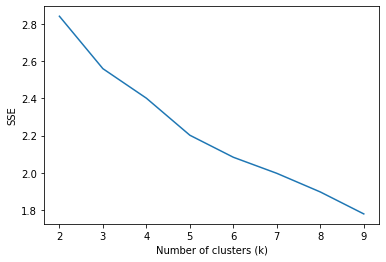

In [28]:
bkk_grouped_clustering = bkk_grouped.drop('District(Khet)', 1)
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(bkk_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

<h5>The “elbow” is not very clear but a slight bend in the curve at k = 3 can be an indication that this might be the best number of clusters <\h5>

<h5>Let's try the silhouette method:<\h5>

In [29]:
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(bkk_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (bkk_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, round(score,4))

2 0.1334
3 0.1174
4 0.1042
5 0.1014
6 0.0958
7 0.0613
8 0.0788
9 0.0771


<h5>The silhouette method indicates that the optimal number of clusters for the dataset is k = 2 since it has the highest score.<\h5>

<h3>K means Clustering<\h3>

In [30]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# Let's see how many stations belong to each cluster
print(Counter(kmeans.labels_))

Counter({1: 28, 0: 18})


In [31]:
bkk_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [32]:
bkk_grouped.head(10)

,Cluster Labels,District(Khet),American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donburi Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Floating Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gay Bar,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pharmacy,Photography Studio,Pizza Place,Pool,Pub,Ramen Restaurant,Recording Studio,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tonkatsu Restaurant,Tour Provider,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,Bang Bon,0.000,0.0,0.100000,0.0,0.1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0,Bang Kapi,0.000,0.0,0.000000,0.0,0.0,0.045455,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.045455,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.045455,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045455,0.000000,0.000000,0.0,0.0,0.045455,0.0,0.000000,0.0,0.0,0.0,0.0,0.045455,0.045455,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.045455,0.045455,0.0,0.045455,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045455,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.000000,0.0,0.045455,0.0,0.045455,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.045455,0.000000,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0

In [33]:
BKK_district_1 = pd.DataFrame(BKK_data,columns=['District(Khet)',  'Latitude',  'Longitude'])
BKK_district_1.head(5)

,District(Khet),Latitude,Longitude
0,Bang Bon,13.659200,100.399100
1,Bang Kapi,13.765833,100.647778
2,Bang Khae,13.696111,100.409444
3,Bang Khen,13.873889,100.596389
4,Bang Kho Laem,13.693333,100.502500


In [34]:
BKK_district_2 = bkk_grouped.join(BKK_district_1.set_index('District(Khet)'), on='District(Khet)')
BKK_merge = BKK_district_2[['District(Khet)','Cluster Labels', 'Latitude', 'Longitude']]
BKK_merge.head(2)

,District(Khet),Cluster Labels,Latitude,Longitude
0,Bang Bon,0,13.659200,100.399100
1,Bang Kapi,0,13.765833,100.647778


In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set the color scheme for the clusters and add markers to the map
colors = ['red','green','blue','black']
fillers = ['red','green','blue','beige']

for lat, lon, poi, cluster in zip(BKK_merge['Latitude'], BKK_merge['Longitude'], BKK_merge['District(Khet)'], BKK_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=fillers[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
# Create new dataframe with only the cluster labels and metro stations:
cluster_info=BKK_merge[['Cluster Labels','District(Khet)']]

# Merge this information with the dataframe that contains all of the venues and columns of the interest:
describe_clusters=BKK_main_cat
describe_clusters=describe_clusters.merge(cluster_info, how="left", on="District(Khet)")
describe_clusters_1=describe_clusters[['District(Khet)','VenueCategory','MainCategory','Cluster Labels']]

# Remove the data that we don't need (i.e. the stations excluded from the clustering)
describe_clusters_1.drop(describe_clusters_1[describe_clusters_1['Cluster Labels'] == 3].index, inplace = True) 
describe_clusters_1.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,District(Khet),VenueCategory,MainCategory,Cluster Labels
0,Bang Bon,Thai Restaurant,Asian Restaurant,0.0
1,Bang Bon,Japanese Restaurant,Asian Restaurant,0.0
2,Bang Bon,Convenience Store,Shop & Service,0.0
3,Bang Bon,Asian Restaurant,Food,0.0
4,Bang Bon,Noodle House,Asian Restaurant,0.0
5,Bang Bon,Shopping Mall,NaN,0.0
6,Bang Bon,Grocery Store,Food & Drink Shop,0.0
7,Bang Bon,Dessert Shop,Food,0.0
8,Bang Bon,Noodle House,Asian Restaurant,0.0
9,Bang Bon,Automotive Shop,Shop & Service,0.0


In [37]:
describe_clusters_1.shape

(1128, 4)

In [38]:
main_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','MainCategory'])['VenueCategory'].count().reset_index()
main_cat_clusters=main_cat_clusters.sort_values(by=['VenueCategory'], ascending=False)
main_cat_cluster_1=main_cat_clusters[main_cat_clusters['Cluster Labels']==0]
main_cat_cluster_1['Percent'] = round(main_cat_cluster_1['VenueCategory']/main_cat_cluster_1['VenueCategory'].sum()*100,1)
main_cat_cluster_1=main_cat_cluster_1.sort_values('MainCategory', ascending=True)
main_cat_cluster_1

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Cluster Labels,MainCategory,VenueCategory,Percent
0,0.0,Arts & Entertainment,2,0.6
1,0.0,Asian Restaurant,113,35.6
2,0.0,Athletics & Sports,5,1.6
3,0.0,Bar,1,0.3
4,0.0,Chinese Restaurant,2,0.6
5,0.0,Clothing Store,1,0.3
6,0.0,Food,129,40.7
7,0.0,Food & Drink Shop,8,2.5
8,0.0,Gym / Fitness Center,2,0.6
9,0.0,Hotel,2,0.6


In [39]:
main_cat_cluster_2=main_cat_clusters[main_cat_clusters['Cluster Labels']==1.0]
main_cat_cluster_2['Percent'] = round(main_cat_cluster_2['VenueCategory']/main_cat_cluster_2['VenueCategory'].sum()*100,1)
main_cat_cluster_2=main_cat_cluster_2.sort_values('MainCategory', ascending=True)
main_cat_cluster_2

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cluster Labels,MainCategory,VenueCategory,Percent
16,1.0,Arts & Entertainment,16,2.3
17,1.0,Asian Restaurant,130,18.8
18,1.0,Athletics & Sports,5,0.7
19,1.0,Bar,15,2.2
20,1.0,Chinese Restaurant,4,0.6
21,1.0,Clothing Store,1,0.1
22,1.0,College & University,1,0.1
23,1.0,Dessert Shop,10,1.4
24,1.0,Food,298,43.0
25,1.0,Food & Drink Shop,12,1.7


In [42]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','VenueCategory'])['MainCategory'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['MainCategory'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==0].head(7)

,Cluster Labels,VenueCategory,MainCategory
45,0.0,Noodle House,87
1,0.0,Asian Restaurant,28
14,0.0,Convenience Store,27
13,0.0,Coffee Shop,18
63,0.0,Thai Restaurant,16
10,0.0,Café,15
11,0.0,Chinese Restaurant,13


In [43]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','VenueCategory'])['MainCategory'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['MainCategory'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==1].head(7)

,Cluster Labels,VenueCategory,MainCategory
94,1.0,Coffee Shop,54
196,1.0,Thai Restaurant,44
88,1.0,Café,42
97,1.0,Convenience Store,40
158,1.0,Noodle House,39
140,1.0,Japanese Restaurant,25
91,1.0,Chinese Restaurant,22


Text(0.5, 1.0, 'Clusters in BKK')

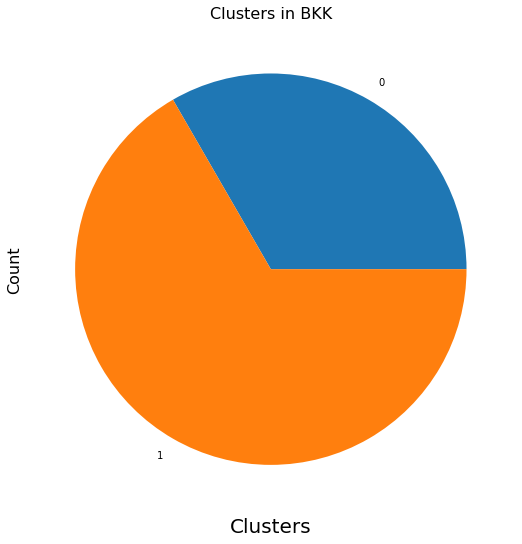

In [50]:
df3 = bkk_grouped['Cluster Labels'].value_counts().sort_values(ascending=True)
df3

plt.figure(figsize = (9, 9))
plt.pie(x = [1 , 2], labels = df3.index)
plt.xlabel("Clusters", fontsize = 20)
plt.ylabel("Count", fontsize = 16)
plt.title("Clusters in BKK", fontsize = 16)

In [69]:
Cluster_targeted1 = bkk_grouped.loc[bkk_grouped['Cluster Labels'] == 1]
Cluster_targeted1[['Cluster Labels','District(Khet)']]

,Cluster Labels,District(Khet)
3,1,Bang Khen
4,1,Bang Kho Laem
5,1,Bang Khun Thian
7,1,Bang Phlat
12,1,Bueng Kum
13,1,Chatuchak
14,1,Din Daeng
15,1,Don Mueang
18,1,Khan Na Yao
19,1,Khlong San


In [70]:
Cluster_targeted1.shape

(28, 156)

In [71]:
Cluster_targeted0 = bkk_grouped.loc[bkk_grouped['Cluster Labels'] == 0]
Cluster_targeted0[['Cluster Labels','District(Khet)']]

,Cluster Labels,District(Khet)
0,0,Bang Bon
1,0,Bang Kapi
2,0,Bang Khae
6,0,Bang Na
8,0,Bang Rak
9,0,Bang Sue
10,0,Bangkok Noi
11,0,Bangkok Yai
16,0,Dusit
17,0,Huai Khwang


In [72]:
Cluster_targeted0.shape

(18, 156)

<h3>Discussion<h3>

<p>The purpose of this study was to cluster different neighborhoods in Bangkok based on areas surrounding every District. Foursquare venue data was used. Although, Foursquare is not widely used in Thailand, that data the we received may imply of characteristic for each cluster. However, Foursquare is mainly focused on food places and for someone who is interested in other kind of features, i.e. housing prices or where the work places are or even schools , it would be interesting to add this kind of information to the analysis.<p>

<h3>Conclusion<h3>

<p>In this study, All the clusters look similar, indicating that Bangkok is quite homogeneous in terms of available venue categories<p>